In [ ]:
# python 3.10

In [ ]:
!pip install -U scikit-learn
!pip install pandas
!pip install tenserflow
!pip install seaborn
!pip install dtaidistance
!pip install keras_multi_head
!pip install keras-mdn-layer
!pip install keras-tcn
!pip install tensorflow-probability
!pip install statsmodels
!pip install PyWavelets
!pip install --upgrade tsmoothie

!pip install matplotlib==3.7.0
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np

In [2]:
from modules.deep_learning_models import Time2Vec4TF, TransformerEncoder, T2VTransformer
from modules.metrics import RMSE, MAPE, SMAPE, DTW, Temporal_loss, PRINT_SCORE, SCORE_2
from modules.ml_models import *
from modules.plots import plot_saisonal_decomp, print_autoCorr
from modules.time_series_function import create_features, check_missing_dates, \
denoise_signal, denoise_dataframe, smooth_data_ExponentialSmoother,\
smooth_data_Kalman, Rolling_statistics, feature_selection_dataframe,\
delete_every_nth_row, shiftting_data, Univariate_X_Y


In [3]:
df=pd.read_csv("data/DrahiX_SIRTA_allzones_20160715_20210520_1h.csv")

# from google.colab import drive 
# drive.mount('/content/gdrive')  
# df = pd.read_csv('gdrive/My Drive/Colab Notebooks/DrahiX_SIRTA_allzones_20160715_20210520_1h.csv', sep=',')

df.rename(columns={"Date and time (UTC)": "Datetime"},inplace=True)
df['Datetime']=pd.to_datetime(df['Datetime'])
df=df.set_index("Datetime")
# df.rename(columns={"T1": "T"},inplace=True)
df.fillna(value=None, method='ffill', axis=None, limit=None, downcast=None,inplace=True)
df=df.drop(['Global_Solar_Flux','Direct_Solar_Flux','Diffuse_Solar_Flux'], axis=1)

df

AirTemp   TGBT    T1    T2    T3    T4    T5    T6  \
Datetime                                                                        
2016-07-15 00:00:00+00:00    12.41   9.37  0.99  2.12  0.19  1.50  1.41  0.26   
2016-07-15 01:00:00+00:00    12.12   9.78  0.99  2.17  0.17  1.69  1.57  0.54   
2016-07-15 02:00:00+00:00    11.54  10.95  1.13  2.31  0.34  1.66  1.68  0.33   
2016-07-15 03:00:00+00:00    11.28  13.73  1.31  2.40  0.89  1.64  1.78  0.54   
2016-07-15 04:00:00+00:00    10.77  14.24  1.17  2.29  0.27  2.10  2.10  0.76   
...                            ...    ...   ...   ...   ...   ...   ...   ...   
2021-05-19 20:00:00+00:00    10.93  15.04  5.31  1.65  2.37  0.51  1.54  0.94   
2021-05-19 21:00:00+00:00    10.10  11.11  2.06  1.02  2.29  0.50  1.50  0.94   
2021-05-19 22:00:00+00:00     9.48  22.12  7.20  2.26  2.31  0.52  1.50  1.02   
2021-05-19 23:00:00+00:00     9.08  20.30  6.12  1.88  2.27  0.59  1.48  0.93   
2021-05-20 00:00:00+00:00     8.85  15.33  2.01  2.63  2.28  0.51  1.39  0.91   

                             T7  
Datetime                         
2016-07-15 00:00:00+00:00  2.64  
2016-07-15 01:00:00+00:00  2.36  
2016-07-15 02:00:00+00:00  3.18  
2016-07-15 03:00:00+00:00  4.81  
2016-07-15 04:00:00+00:00  5.25  
...                         ...  
2021-05-19 20:00:00+00:00  2.22  
2021-05-19 21:00:00+00:00  2.34  
2021-05-19 22:00:00+00:00  6.72  
2021-05-19 23:00:00+00:00  6.48  
2021-05-20 00:00:00+00:00  4.92  

[42481 rows x 9 columns]

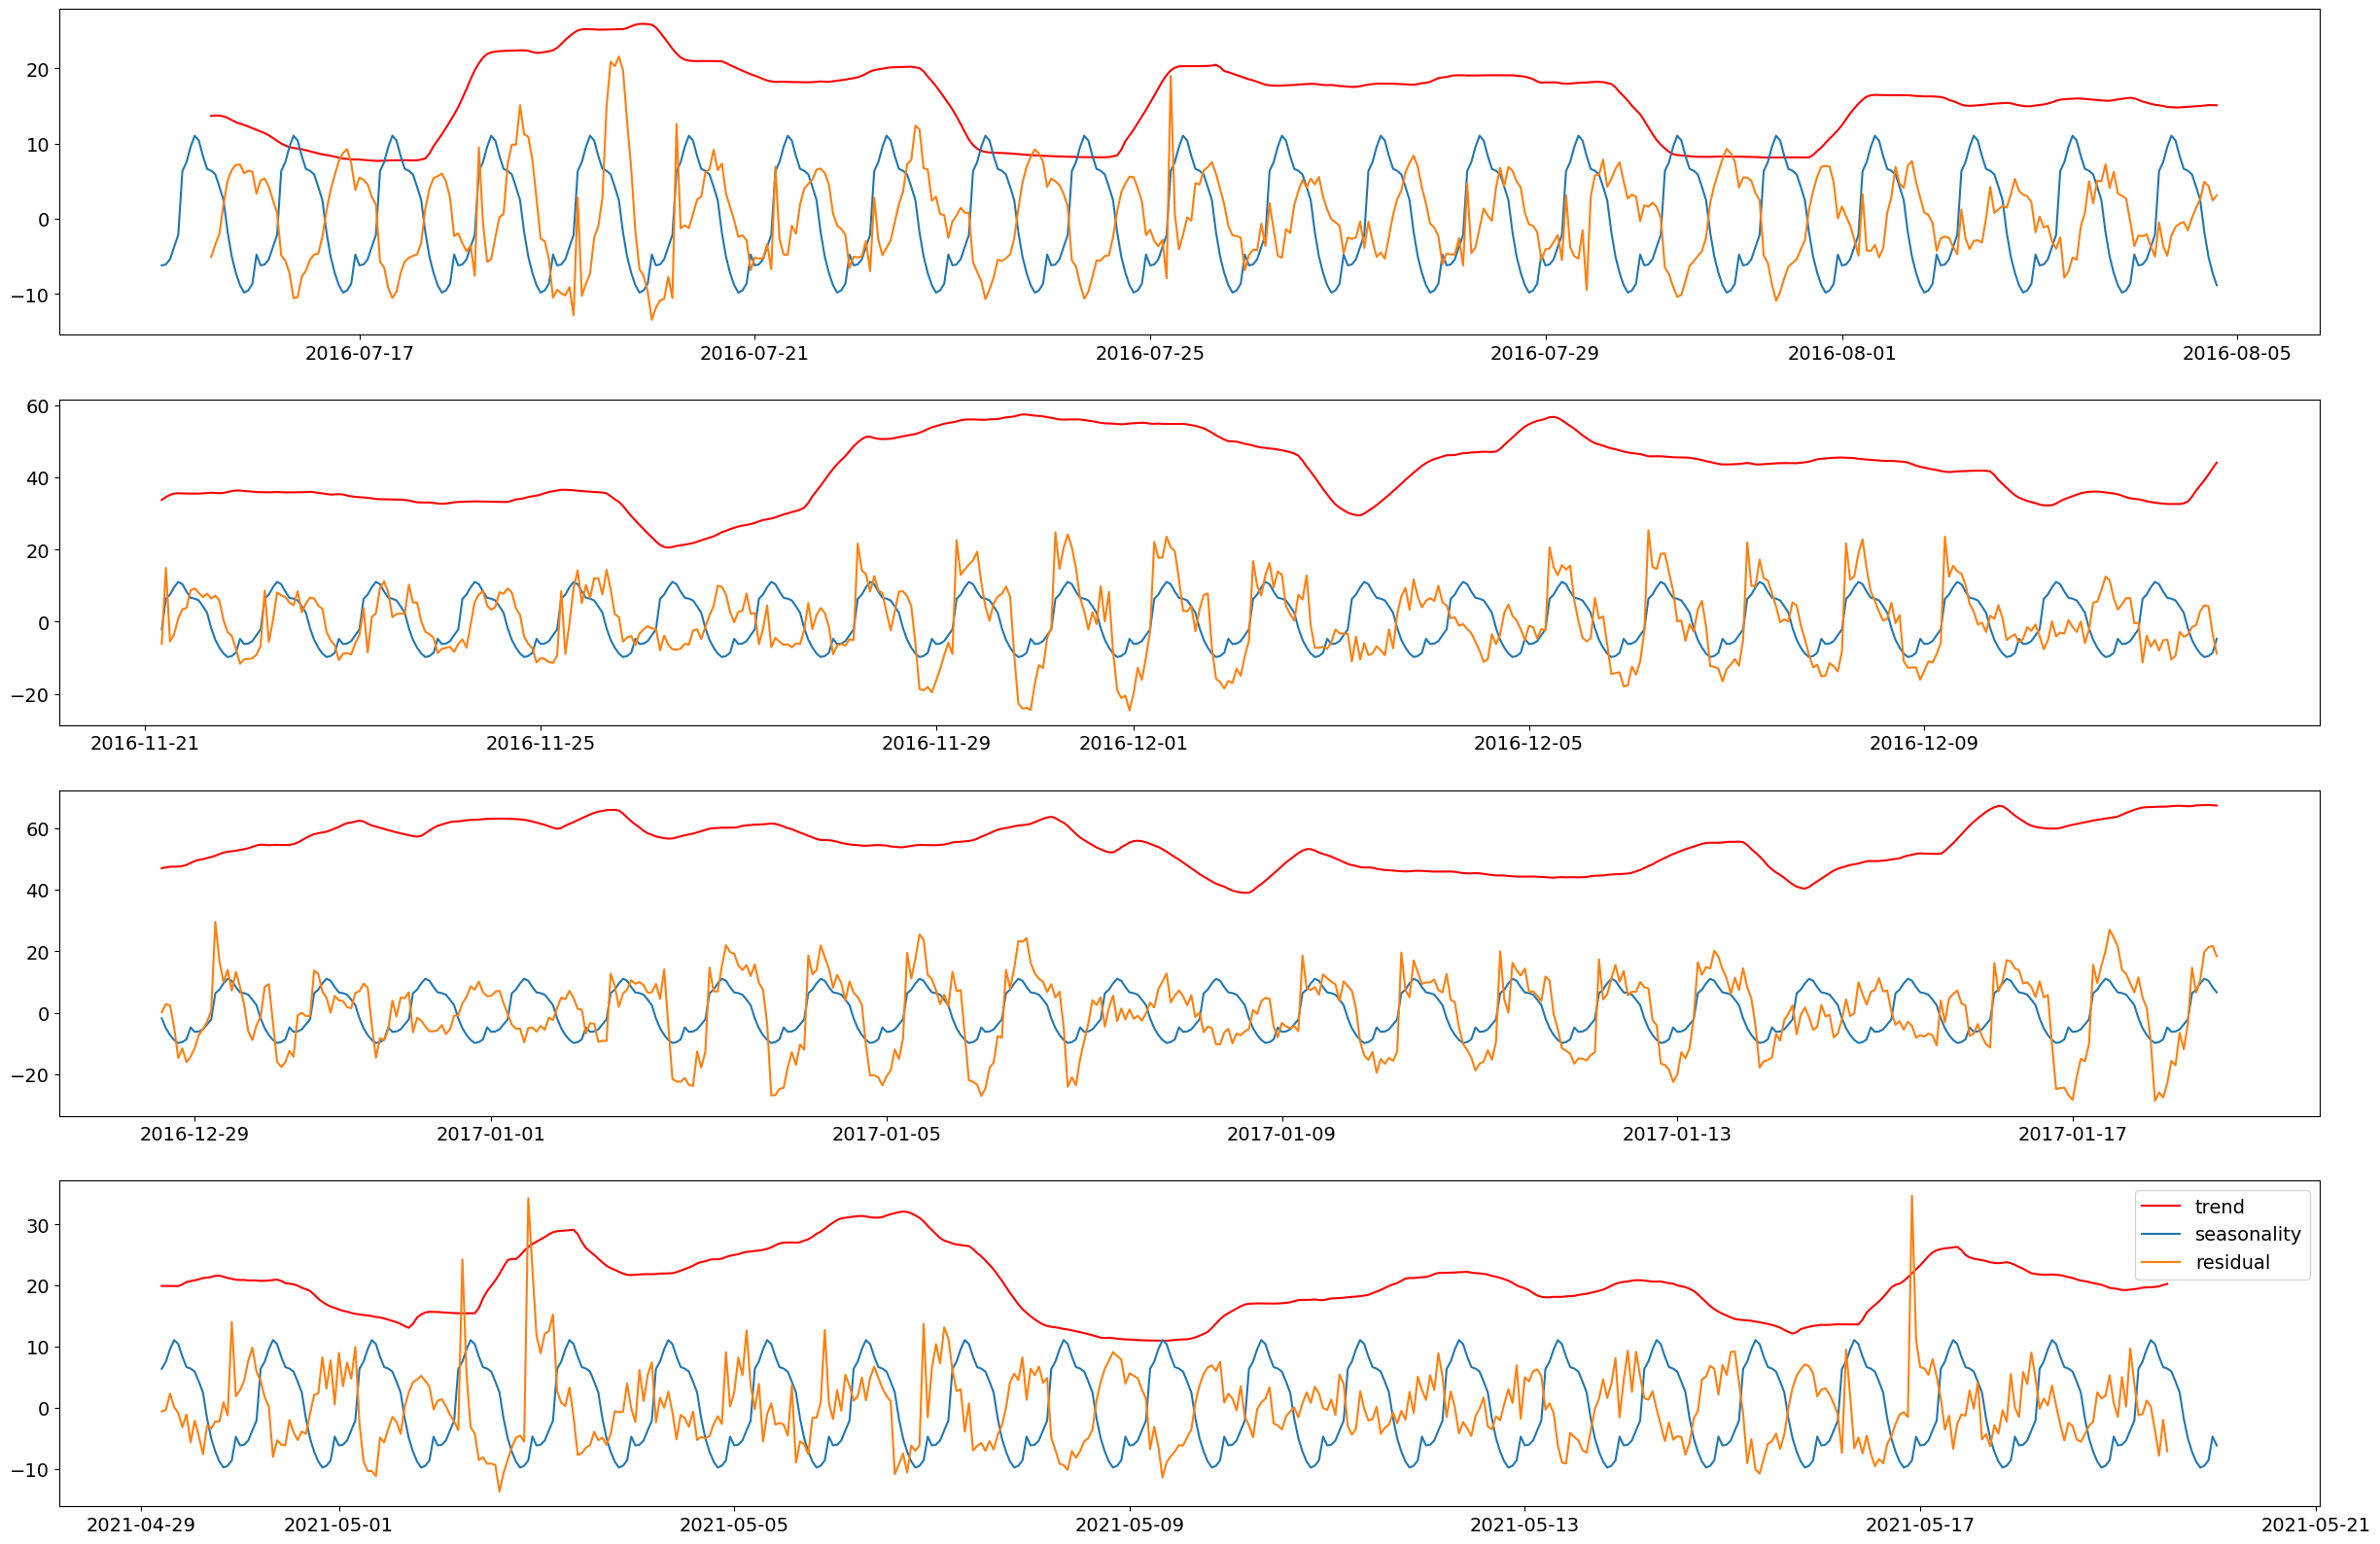

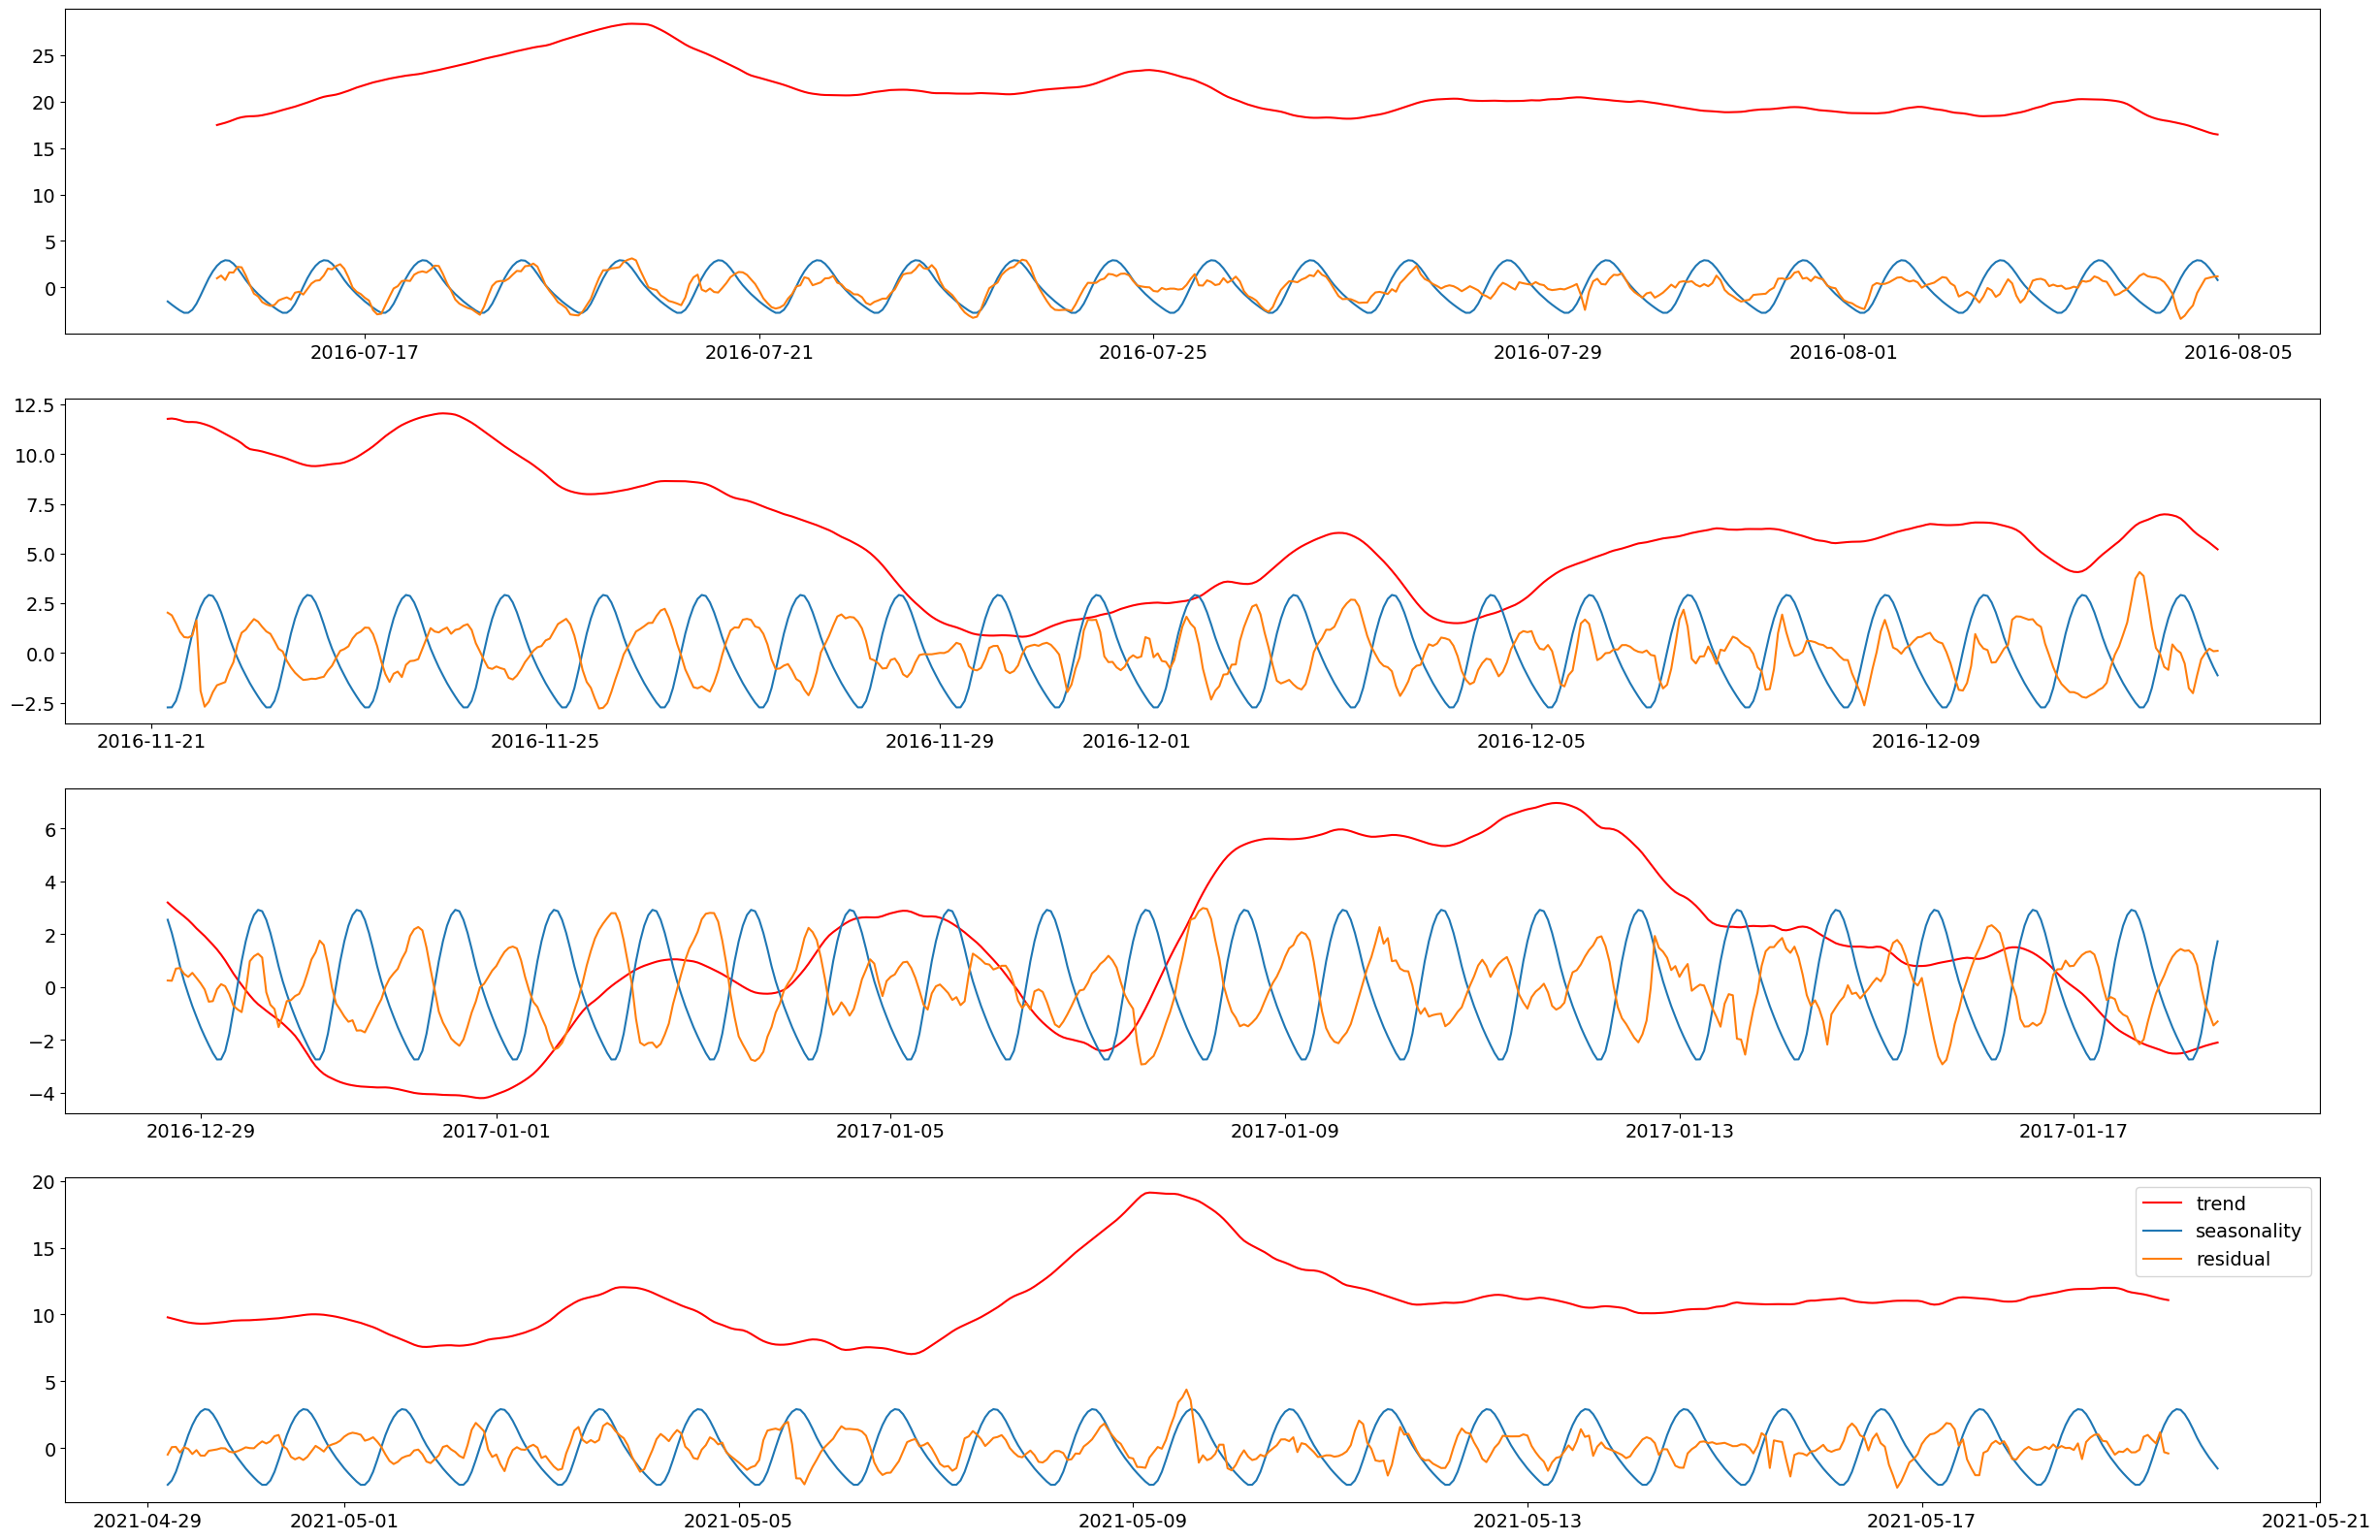

In [4]:
plot_saisonal_decomp(df['TGBT'])
plot_saisonal_decomp(df['AirTemp'])

# Compute seasonal decomposition to filter the data of TGBT and Airtemp

<Axes: xlabel='Datetime'>

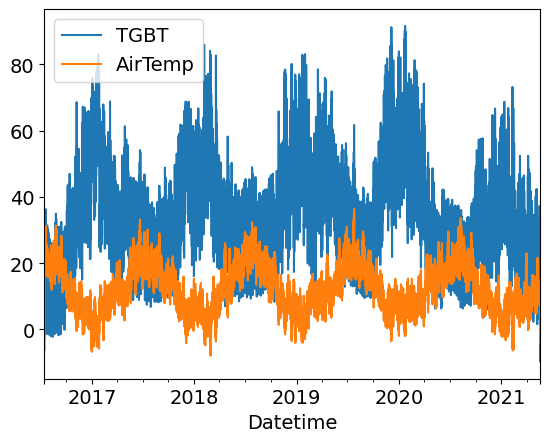

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose


seasonal_decompose_TGBT = seasonal_decompose(df['TGBT'])
seasonal_decompose_AirTemp = seasonal_decompose(df['AirTemp'])

# no .resid !

# Create new DataFrame with the index of df
df_saisonal = pd.DataFrame(index=df.index)

# Add seasonal decomposition results to the new DataFrame
df_saisonal['TGBT'] = seasonal_decompose_TGBT.trend.add(seasonal_decompose_TGBT.seasonal, fill_value=0)
df_saisonal['AirTemp'] = seasonal_decompose_AirTemp.trend.add(seasonal_decompose_AirTemp.seasonal, fill_value=0)

df_saisonal.plot()

# Create features

In [6]:
window_size = 24*7
Target_column = 'TGBT'

data_temp, colname_data_temp= shiftting_data(df,n_in=window_size-1,n_out=24,Target_column=Target_column)
# data_temp = Rolling_statistics(data =data_temp , window = 24, target =Target_column )
data_temp = Rolling_statistics(data =data_temp , window = 24*7, target =Target_column )

data_temp = delete_every_nth_row(data_temp, n = 24 )

In [7]:
data_temp

AirTemp   TGBT     T1    T2    T3    T4    T5  \
Datetime                                                                   
2016-07-28 22:00:00+00:00    19.73   7.88   1.05  1.43  0.22  1.40  0.87   
2016-07-29 22:00:00+00:00    18.52   8.79   0.76  1.34  0.21  1.16  2.50   
2016-07-30 22:00:00+00:00    16.87   7.25   0.76  1.54  0.15  1.15  0.87   
2016-07-31 22:00:00+00:00    18.10   7.38   0.76  1.35  0.20  1.18  0.78   
2016-08-01 22:00:00+00:00    18.98   7.11   0.76  1.34  0.21  1.16  0.98   
...                            ...    ...    ...   ...   ...   ...   ...   
2021-05-14 22:00:00+00:00    10.18  13.86   4.13  1.69  1.19  0.55  1.14   
2021-05-15 22:00:00+00:00    10.12  10.38   2.64  1.20  1.17  0.92  1.14   
2021-05-16 22:00:00+00:00     9.48  48.09  11.59  5.21  1.11  1.19  1.01   
2021-05-17 22:00:00+00:00     9.44  20.52   6.65  1.47  2.43  0.55  1.35   
2021-05-18 22:00:00+00:00    11.29  16.29   6.29  1.38  2.49  0.80  1.52   

                             T6     T7  TGBT -1h  TGBT -2h  TGBT -3h  \
Datetime                                                               
2016-07-28 22:00:00+00:00  0.26   2.43      8.13      8.24     10.89   
2016-07-29 22:00:00+00:00  0.14   2.43      8.76      8.60     12.44   
2016-07-30 22:00:00+00:00  0.14   2.41      7.46      7.78      7.44   
2016-07-31 22:00:00+00:00  0.39   2.52      8.14      7.31      7.62   
2016-08-01 22:00:00+00:00  0.14   2.36      7.30      7.30     10.32   
...                         ...    ...       ...       ...       ...   
2021-05-14 22:00:00+00:00  0.94   3.96     13.96     12.55     13.70   
2021-05-15 22:00:00+00:00  0.94   2.07     10.49     10.34     10.35   
2021-05-16 22:00:00+00:00  0.93  25.92     10.26     10.19     10.37   
2021-05-17 22:00:00+00:00  0.94   6.80     11.99     13.48     10.58   
2021-05-18 22:00:00+00:00  0.94   2.46     12.30     11.83     13.95   

                           TGBT -4h  TGBT -5h  TGBT -6h  TGBT -7h  TGBT -8h  \
Datetime                                                                      
2016-07-28 22:00:00+00:00     15.94     18.99     23.70     28.50     27.75   
2016-07-29 22:00:00+00:00     17.19     19.14     21.46     24.83     30.33   
2016-07-30 22:00:00+00:00      7.35      7.70      8.53      8.25      8.20   
2016-07-31 22:00:00+00:00      7.49      7.16      7.60      7.86      8.35   
2016-08-01 22:00:00+00:00     14.04     19.06     21.73     23.03     25.39   
...                             ...       ...       ...       ...       ...   
2021-05-14 22:00:00+00:00     10.76     12.31     11.95     14.52     19.31   
2021-05-15 22:00:00+00:00     10.42     10.35     10.60     10.86     10.59   
2021-05-16 22:00:00+00:00     10.21     10.03     11.12     11.46     13.23   
2021-05-17 22:00:00+00:00     13.63     12.45     17.87     21.42     32.65   
2021-05-18 22:00:00+00:00     10.90     12.56     14.56     17.71     20.07   

                           TGBT -9h  TGBT -10h  TGBT -11h  TGBT -12h  \
Datetime                                                               
2016-07-28 22:00:00+00:00     31.78      29.66      25.48      27.88   
2016-07-29 22:00:00+00:00     30.00      30.37      27.78      17.04   
2016-07-30 22:00:00+00:00      9.23       9.04       8.72       8.47   
2016-07-31 22:00:00+00:00      8.72       8.71       8.46       8.67   
2016-08-01 22:00:00+00:00     29.26      25.72      23.92      20.86   
...                             ...        ...        ...        ...   
2021-05-14 22:00:00+00:00     21.26      21.45      24.58      23.39   
2021-05-15 22:00:00+00:00     14.99      14.46      14.43      13.85   
2021-05-16 22:00:00+00:00     13.12      15.11      17.62      15.27   
2021-05-17 22:00:00+00:00     30.14      33.82      30.34      33.02   
2021-05-18 22:00:00+00:00     24.12      25.31      22.80      27.34   

                           TGBT -13h  TGBT -14h  TGBT -15h  TGBT -16h  \
Datetime                                                       

In [8]:
def create_exited_feature(df, columns, k = 1.3 ,verbose = True):
    tmp = df.copy()
    
    for col in columns:
        mean = tmp[col].mean()
        std = tmp[col].std()
        # k = 1.3  # You can adjust this value based on your data distribution
        threshold = mean - k * std
        
        exited_col_name = f"{col}_schedule"
        tmp[exited_col_name] = (tmp[col] > threshold).astype(int)
        
        if verbose: 
            count = tmp[exited_col_name].sum()
            proportion = (count / tmp.shape[0]) * 100
            print(f"{col} threshold: {threshold:.1f}, mean: {mean:.2f}, std: {std:.2f}, Number of 1s: {count}, Proportion: {proportion:.0f}%")
    
    return tmp

columns = [col for col in data_temp if '+' in col]
result_df = create_exited_feature(data_temp, columns, k = 1.0, verbose =True)

TGBT +1h threshold: 13.6, mean: 30.35, std: 16.73, Number of 1s: 1664, Proportion: 94%
TGBT +2h threshold: 14.7, mean: 28.90, std: 14.17, Number of 1s: 1659, Proportion: 94%
TGBT +3h threshold: 15.4, mean: 29.02, std: 13.61, Number of 1s: 1659, Proportion: 94%
TGBT +4h threshold: 15.9, mean: 29.71, std: 13.81, Number of 1s: 1649, Proportion: 94%
TGBT +5h threshold: 17.7, mean: 31.36, std: 13.63, Number of 1s: 1606, Proportion: 91%
TGBT +6h threshold: 18.4, mean: 32.96, std: 14.57, Number of 1s: 1590, Proportion: 90%
TGBT +7h threshold: 22.2, mean: 41.41, std: 19.19, Number of 1s: 1531, Proportion: 87%
TGBT +8h threshold: 23.8, mean: 42.63, std: 18.79, Number of 1s: 1507, Proportion: 86%
TGBT +9h threshold: 25.2, mean: 44.66, std: 19.48, Number of 1s: 1479, Proportion: 84%
TGBT +10h threshold: 25.3, mean: 46.16, std: 20.81, Number of 1s: 1477, Proportion: 84%
TGBT +11h threshold: 24.5, mean: 45.50, std: 21.01, Number of 1s: 1476, Proportion: 84%
TGBT +12h threshold: 23.6, mean: 43.44, s

In [9]:
result_df.corr()

AirTemp      TGBT        T1        T2        T3  \
AirTemp             1.000000 -0.641823 -0.665828 -0.676254 -0.660588   
TGBT               -0.641823  1.000000  0.765335  0.663889  0.519439   
T1                 -0.665828  0.765335  1.000000  0.599523  0.529569   
T2                 -0.676254  0.663889  0.599523  1.000000  0.476615   
T3                 -0.660588  0.519439  0.529569  0.476615  1.000000   
...                      ...       ...       ...       ...       ...   
TGBT +20h_schedule -0.117422  0.341973  0.062930  0.334279  0.114526   
TGBT +21h_schedule -0.114142  0.354237  0.049817  0.340072  0.098724   
TGBT +22h_schedule -0.122251  0.341793  0.053692  0.330489  0.110882   
TGBT +23h_schedule -0.121761  0.345064  0.060548  0.336353  0.104674   
TGBT +24h_schedule -0.155434  0.352034  0.106547  0.326199  0.145634   

                          T4        T5        T6        T7  TGBT -1h  \
AirTemp            -0.606934 -0.656047 -0.195049 -0.464193 -0.628551   
TGBT                0.344559  0.520462  0.594864  0.824025  0.924866   
T1                  0.359712  0.444351  0.200880  0.714755  0.625245   
T2                  0.744407  0.465886  0.110196  0.491358  0.638570   
T3                  0.416119  0.519769  0.169571  0.330420  0.501615   
...                      ...       ...       ...       ...       ...   
TGBT +20h_schedule  0.181798  0.308002  0.211520  0.142733  0.416084   
TGBT +21h_schedule  0.179805  0.301737  0.208186  0.161228  0.422434   
TGBT +22h_schedule  0.151174  0.320206  0.190641  0.151927  0.408736   
TGBT +23h_schedule  0.157358  0.309938  0.189423  0.159016  0.406853   
TGBT +24h_schedule  0.139973  0.271938  0.175804  0.195018  0.379132   

                    TGBT -2h  TGBT -3h  TGBT -4h  TGBT -5h  TGBT -6h  \
AirTemp            -0.620366 -0.613410 -0.551638 -0.517511 -0.439607   
TGBT                0.921848  0.868664  0.753616  0.682906  0.522253   
T1                  0.629074  0.582960  0.497434  0.458583  0.330020   
T2                  0.656404  0.688946  0.669375  0.628038  0.584444   
T3                  0.502913  0.521680  0.496275  0.482420  0.414366   
...                      ...       ...       ...       ...       ...   
TGBT +20h_schedule  0.429451  0.459657  0.455311  0.449850  0.417451   
TGBT +21h_schedule  0.433995  0.462129  0.448222  0.435313  0.397325   
TGBT +22h_schedule  0.417631  0.436653  0.420948  0.403340  0.364173   
TGBT +23h_schedule  0.418404  0.435733  0.420541  0.403859  0.364662   
TGBT +24h_schedule  0.386648  0.395958  0.375794  0.356511  0.320473   

                    TGBT -7h  TGBT -8h  TGBT -9h  TGBT -10h  TGBT -11h  \
AirTemp            -0.484156 -0.518266 -0.521491  -0.545386  -0.596047   
TGBT                0.562261  0.587555  0.606361   0.621780   0.637898   
T1                  0.374696  0.414629  0.422986   0.441047   0.466217   
T2                  0.500420  0.520310  0.539247   0.556889   0.585847   
T3                  0.448376  0.478580  0.472779   0.486968   0.523567   
...                      ...       ...       ...        ...        ...   
TGBT +20h_schedule  0.381831  0.361124  0.370255   0.370237   0.365007   
TGBT +21h_schedule  0.355208  0.338702  0.347517   0.350270   0.346716   
TGBT +22h_schedule  0.331220  0.314154  0.322848   0.326152   0.326628   
TGBT +23h_schedule  0.328154  0.314328  0.323346   0.328189   0.326873   
TGBT +24h_schedule  0.284273  0.278688  0.286454   0.290435   0.292458   

                    TGBT -12h  TGBT -13h  TGBT -14h  TGBT -15h  TGBT -16h  \
AirTemp             -0.638455  -0.648895  -0.667705  -0.681640  -0.691135   
TGBT                 0.646127   0.647930   0.667520   0.701641   0.726090   
T1                   0.493010   0.507329   0.521906   0.533823   0.555833   
T2                   0.603303   0.599985   0.606341   0.607317   0.635831   
T3                   0.555341   0.565558   0.572717   0.577218   0.582167   
...                       ...        ...        ...        ...        ...  

## find best k that maimize the sum of correlation

In [10]:
def find_best_k(df, columns):
    best_k = None
    max_corr_sum = -1  # Initialize with a negative value
    
    for k in np.arange(0, 2, 0.1):  # Assuming you want to test k values from 1 to 20
        tmp = df.copy()
        correlations = []
        
        for col in columns:
            mean = tmp[col].mean()
            std = tmp[col].std()
            threshold = mean - k * std
            
            exited_col_name = f"{col}_schedule"
            tmp[exited_col_name] = (tmp[col] > threshold).astype(int)
            
            correlation = tmp[col].corr(tmp[exited_col_name])
            correlations.append(correlation)
        
        corr_sum = sum(correlations)
        print(f"For k={k:.2f}, Sum of Correlations: {corr_sum:.2f}")
        
        if corr_sum > max_corr_sum:
            max_corr_sum = corr_sum
            best_k = k
    
    print(f"Best k value: {best_k:.2f}, Maximum Sum of Correlations: {max_corr_sum:.2f}")
    return best_k


columns = [col for col in data_temp if '+' in col]

best_k_value = find_best_k(data_temp, columns)


For k=0.00, Sum of Correlations: 19.45
For k=0.10, Sum of Correlations: 19.16
For k=0.20, Sum of Correlations: 18.76
For k=0.30, Sum of Correlations: 18.28
For k=0.40, Sum of Correlations: 17.67
For k=0.50, Sum of Correlations: 16.95
For k=0.60, Sum of Correlations: 16.12
For k=0.70, Sum of Correlations: 15.05
For k=0.80, Sum of Correlations: 13.80
For k=0.90, Sum of Correlations: 12.61
For k=1.00, Sum of Correlations: 11.58
For k=1.10, Sum of Correlations: 10.61
For k=1.20, Sum of Correlations: 9.51
For k=1.30, Sum of Correlations: 8.28
For k=1.40, Sum of Correlations: 7.18
For k=1.50, Sum of Correlations: 6.23
For k=1.60, Sum of Correlations: 5.20
For k=1.70, Sum of Correlations: 4.15
For k=1.80, Sum of Correlations: nan
For k=1.90, Sum of Correlations: nan
Best k value: 0.00, Maximum Sum of Correlations: 19.45


In [11]:
def create_exited_feature_with_iqr(df, column_name, verbose =True):
    tmp = df.copy()
    for col in column_name:
        # Calculate Q1 and Q3
        Q1 = tmp[col].quantile(0.25)
        Q3 = tmp[col].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        # Set the lower and upper thresholds using IQR
        threshold_lower = Q1 - 0.5 * IQR
        threshold_upper = Q3 + 1.5 * IQR

        # Create the 'Exited' feature based on the IQR threshold
        exited_col_name = f"{col} schedule"
        # df[exited_col_name] = (df[column_name] < threshold_lower) | (df[column_name] > threshold_upper)
        tmp[exited_col_name] = tmp[col] > threshold_lower
        tmp[exited_col_name] = tmp[exited_col_name].astype(int)
        
        if verbose: 
            count = tmp[exited_col_name].sum()
            proportion = (count / tmp.shape[0]) * 100
            print(f"Number of 1s: {count} in {col} , Proportion: {proportion:.0f}%")
    
        
    return tmp

columns = [col for col in data_temp if '+' in col]

result_df_iqr = create_exited_feature_with_iqr(data_temp, columns,verbose = True)
result_df_iqr


Number of 1s: 1695 in TGBT +1h , Proportion: 96%
Number of 1s: 1686 in TGBT +2h , Proportion: 96%
Number of 1s: 1690 in TGBT +3h , Proportion: 96%
Number of 1s: 1689 in TGBT +4h , Proportion: 96%
Number of 1s: 1694 in TGBT +5h , Proportion: 96%
Number of 1s: 1695 in TGBT +6h , Proportion: 96%
Number of 1s: 1744 in TGBT +7h , Proportion: 99%
Number of 1s: 1740 in TGBT +8h , Proportion: 99%
Number of 1s: 1730 in TGBT +9h , Proportion: 98%
Number of 1s: 1736 in TGBT +10h , Proportion: 99%
Number of 1s: 1732 in TGBT +11h , Proportion: 98%
Number of 1s: 1735 in TGBT +12h , Proportion: 98%
Number of 1s: 1727 in TGBT +13h , Proportion: 98%
Number of 1s: 1721 in TGBT +14h , Proportion: 98%
Number of 1s: 1723 in TGBT +15h , Proportion: 98%
Number of 1s: 1723 in TGBT +16h , Proportion: 98%
Number of 1s: 1714 in TGBT +17h , Proportion: 97%
Number of 1s: 1706 in TGBT +18h , Proportion: 97%
Number of 1s: 1683 in TGBT +19h , Proportion: 96%
Number of 1s: 1658 in TGBT +20h , Proportion: 94%
Number of

AirTemp   TGBT     T1    T2    T3    T4    T5  \
Datetime                                                                   
2016-07-22 22:00:00+00:00    19.72   8.01   0.80  1.26  0.22  1.25  0.93   
2016-07-23 22:00:00+00:00    19.12   7.34   0.80  1.27  0.32  1.23  0.80   
2016-07-24 22:00:00+00:00    22.69   7.34   0.81  1.28  0.23  1.23  0.79   
2016-07-25 22:00:00+00:00    18.70   7.82   1.02  1.30  0.34  1.32  0.83   
2016-07-26 22:00:00+00:00    16.18   8.12   0.91  1.62  0.17  1.28  1.32   
...                            ...    ...    ...   ...   ...   ...   ...   
2021-05-14 22:00:00+00:00    10.18  13.86   4.13  1.69  1.19  0.55  1.14   
2021-05-15 22:00:00+00:00    10.12  10.38   2.64  1.20  1.17  0.92  1.14   
2021-05-16 22:00:00+00:00     9.48  48.09  11.59  5.21  1.11  1.19  1.01   
2021-05-17 22:00:00+00:00     9.44  20.52   6.65  1.47  2.43  0.55  1.35   
2021-05-18 22:00:00+00:00    11.29  16.29   6.29  1.38  2.49  0.80  1.52   

                             T6     T7  TGBT -1h  TGBT -2h  TGBT -3h  \
Datetime                                                               
2016-07-22 22:00:00+00:00  0.17   3.19      8.01     10.78     11.91   
2016-07-23 22:00:00+00:00  0.17   2.59      7.59      7.88      7.88   
2016-07-24 22:00:00+00:00  0.17   2.66      7.30      7.60      7.88   
2016-07-25 22:00:00+00:00  0.15   2.67      7.31      7.33      9.72   
2016-07-26 22:00:00+00:00  0.17   2.39      7.79      7.94     10.22   
...                         ...    ...       ...       ...       ...   
2021-05-14 22:00:00+00:00  0.94   3.96     13.96     12.55     13.70   
2021-05-15 22:00:00+00:00  0.94   2.07     10.49     10.34     10.35   
2021-05-16 22:00:00+00:00  0.93  25.92     10.26     10.19     10.37   
2021-05-17 22:00:00+00:00  0.94   6.80     11.99     13.48     10.58   
2021-05-18 22:00:00+00:00  0.94   2.46     12.30     11.83     13.95   

                           TGBT -4h  TGBT -5h  TGBT -6h  TGBT -7h  TGBT -8h  \
Datetime                                                                      
2016-07-22 22:00:00+00:00     18.30     21.32     30.13     35.03     32.32   
2016-07-23 22:00:00+00:00      8.26      8.33      8.18      8.55      8.24   
2016-07-24 22:00:00+00:00      7.88      7.70      7.66      8.38      7.63   
2016-07-25 22:00:00+00:00     14.40     19.12     24.67     30.41     31.49   
2016-07-26 22:00:00+00:00     13.53     18.43     20.73     25.79     26.35   
...                             ...       ...       ...       ...       ...   
2021-05-14 22:00:00+00:00     10.76     12.31     11.95     14.52     19.31   
2021-05-15 22:00:00+00:00     10.42     10.35     10.60     10.86     10.59   
2021-05-16 22:00:00+00:00     10.21     10.03     11.12     11.46     13.23   
2021-05-17 22:00:00+00:00     13.63     12.45     17.87     21.42     32.65   
2021-05-18 22:00:00+00:00     10.90     12.56     14.56     17.71     20.07   

                           TGBT -9h  TGBT -10h  TGBT -11h  TGBT -12h  \
Datetime                                                               
2016-07-22 22:00:00+00:00     33.39      30.20      28.78      28.06   
2016-07-23 22:00:00+00:00      9.41       9.55      10.00       9.39   
2016-07-24 22:00:00+00:00      9.16       9.04       9.31       8.85   
2016-07-25 22:00:00+00:00     32.65      31.25      31.71      28.44   
2016-07-26 22:00:00+00:00     28.99      27.96      26.29      24.25   
...                             ...        ...        ...        ...   
2021-05-14 22:00:00+00:00     21.26      21.45      24.58      23.39   
2021-05-15 22:00:00+00:00     14.99      14.46      14.43      13.85   
2021-05-16 22:00:00+00:00     13.12      15.11      17.62      15.27   
2021-05-17 22:00:00+00:00     30.14      33.82      30.34      33.02   
2021-05-18 22:00:00+00:00     24.12      25.31      22.80      27.34   

                           TGBT -13h  TGBT -14h  TGBT -15h  TGBT -16h  \
Datetime                                                       

In [12]:
result_df_iqr.corr()

AirTemp      TGBT        T1        T2        T3  \
AirTemp             1.000000 -0.641823 -0.665828 -0.676254 -0.660588   
TGBT               -0.641823  1.000000  0.765335  0.663889  0.519439   
T1                 -0.665828  0.765335  1.000000  0.599523  0.529569   
T2                 -0.676254  0.663889  0.599523  1.000000  0.476615   
T3                 -0.660588  0.519439  0.529569  0.476615  1.000000   
...                      ...       ...       ...       ...       ...   
TGBT +20h schedule -0.063095  0.270967  0.018446  0.268376  0.046982   
TGBT +21h schedule -0.122618  0.334777  0.077943  0.319824  0.113219   
TGBT +22h schedule -0.145520  0.330937  0.085428  0.310786  0.129764   
TGBT +23h schedule -0.141566  0.331486  0.088757  0.310677  0.129417   
TGBT +24h schedule -0.185099  0.335603  0.139573  0.298707  0.195779   

                          T4        T5        T6        T7  TGBT -1h  \
AirTemp            -0.606934 -0.656047 -0.195049 -0.464193 -0.628551   
TGBT                0.344559  0.520462  0.594864  0.824025  0.924866   
T1                  0.359712  0.444351  0.200880  0.714755  0.625245   
T2                  0.744407  0.465886  0.110196  0.491358  0.638570   
T3                  0.416119  0.519769  0.169571  0.330420  0.501615   
...                      ...       ...       ...       ...       ...   
TGBT +20h schedule  0.133139  0.267042  0.152443  0.121307  0.335470   
TGBT +21h schedule  0.145992  0.322598  0.175005  0.155073  0.391053   
TGBT +22h schedule  0.145936  0.314150  0.173575  0.151490  0.383138   
TGBT +23h schedule  0.142524  0.321888  0.174017  0.148482  0.388959   
TGBT +24h schedule  0.115587  0.284675  0.159244  0.178994  0.347572   

                    TGBT -2h  TGBT -3h  TGBT -4h  TGBT -5h  TGBT -6h  \
AirTemp            -0.620366 -0.613410 -0.551638 -0.517511 -0.439607   
TGBT                0.921848  0.868664  0.753616  0.682906  0.522253   
T1                  0.629074  0.582960  0.497434  0.458583  0.330020   
T2                  0.656404  0.688946  0.669375  0.628038  0.584444   
T3                  0.502913  0.521680  0.496275  0.482420  0.414366   
...                      ...       ...       ...       ...       ...   
TGBT +20h schedule  0.344538  0.365088  0.363789  0.358979  0.327730   
TGBT +21h schedule  0.399745  0.413344  0.397439  0.384397  0.344446   
TGBT +22h schedule  0.390973  0.402653  0.379916  0.364251  0.325852   
TGBT +23h schedule  0.397572  0.407402  0.388227  0.371656  0.330618   
TGBT +24h schedule  0.356510  0.358235  0.331945  0.310033  0.273938   

                    TGBT -7h  TGBT -8h  TGBT -9h  TGBT -10h  TGBT -11h  \
AirTemp            -0.484156 -0.518266 -0.521491  -0.545386  -0.596047   
TGBT                0.562261  0.587555  0.606361   0.621780   0.637898   
T1                  0.374696  0.414629  0.422986   0.441047   0.466217   
T2                  0.500420  0.520310  0.539247   0.556889   0.585847   
T3                  0.448376  0.478580  0.472779   0.486968   0.523567   
...                      ...       ...       ...        ...        ...   
TGBT +20h schedule  0.300042  0.281166  0.292017   0.290862   0.283687   
TGBT +21h schedule  0.309980  0.301145  0.308926   0.314889   0.313661   
TGBT +22h schedule  0.300009  0.290226  0.296130   0.301939   0.303184   
TGBT +23h schedule  0.298842  0.289919  0.295438   0.302697   0.303245   
TGBT +24h schedule  0.250054  0.248841  0.254118   0.259364   0.262816   

                    TGBT -12h  TGBT -13h  TGBT -14h  TGBT -15h  TGBT -16h  \
AirTemp             -0.638455  -0.648895  -0.667705  -0.681640  -0.691135   
TGBT                 0.646127   0.647930   0.667520   0.701641   0.726090   
T1                   0.493010   0.507329   0.521906   0.533823   0.555833   
T2                   0.603303   0.599985   0.606341   0.607317   0.635831   
T3                   0.555341   0.565558   0.572717   0.577218   0.582167   
...                       ...        ...        ...        ...        ...  

# Transform to univariate time series problem + split train / test

In [13]:
dataT = data_temp.drop(columns=['TGBT', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])

# split train and validation
n = len(dataT)
train_T = dataT[0:int(n*0.9)]
val_T = dataT[int(n*0.9):]

# FEATURES and TARGET
TARGET=[col for col in dataT.columns if '+' in col]
FEATURES= [col for col in dataT.columns if col not in TARGET]

X_train=train_T[FEATURES]
y_train=train_T[TARGET]

X_val=val_T[FEATURES]
y_val=val_T[TARGET]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1585, 172)
(1585, 24)
(177, 172)
(177, 24)


# Scale

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the StandardScaler and MinMaxScaler
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Scale the features using StandardScaler
X_train_standard_scaled = standard_scaler.fit_transform(X_train)
X_val_standard_scaled = standard_scaler.transform(X_val)

# Scale the features using MinMaxScaler
X_train_minmax_scaled = minmax_scaler.fit_transform(X_train)
X_val_minmax_scaled = minmax_scaler.transform(X_val)

# Now, X_train_standard_scaled, X_val_standard_scaled, X_train_minmax_scaled, and X_val_minmax_scaled
# contain the scaled features for training and validation sets, using StandardScaler and MinMaxScaler respectively
print("Standard Scaled - Shape of X_train:", X_train_standard_scaled.shape)
print("Standard Scaled - Shape of X_val:", X_val_standard_scaled.shape)

print("MinMax Scaled - Shape of X_train:", X_train_minmax_scaled.shape)
print("MinMax Scaled - Shape of X_val:", X_val_minmax_scaled.shape)


You typically don't scale the target variables (`y_train` and `y_val`) in regression problems. Scaling is generally applied to the input features to ensure that they are on a similar scale, which can help improve the performance and convergence of many machine learning algorithms.

Scaling the target variables is not a common practice because it does not provide the same benefits as scaling the features. Machine learning algorithms aim to minimize or maximize an objective function (such as mean squared error in regression problems) to find the best-fitting model. Scaling the targets does not affect the shape of the objective function, so it doesn't change the optimal solution for the model.

In most cases, you do not need to use `inverse_transform` for the target variables because the predictions made by your model will be on the same scale as your original target variables. If you used the scaled features for training, make sure to use the same scaler object to transform any new data before making predictions with the trained model. This ensures that the input features to the model are consistent with what the model was trained on.

# ML baseline

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# from sklearn.model_selection import GridSearchCV


List_model = [LinearRegression(),KNeighborsRegressor(),MLPRegressor(),XGBRegressor()]

for model in List_model:
    

    model.fit(X_train_standard_scaled,y_train)
    
    y_pred=model.predict(X_val_standard_scaled)
    y_pred=pd.DataFrame(y_pred)

    print(f'{model}')
    PRINT_SCORE(y_val, y_pred)
    

    RESULT_3=SCORE_2(model_name= f"{model}", y_pred=y_pred, y_val=y_val,target_column="TGBT", window_size=24*7, steps_ahead=24, RESULT_3=RESULT_3 )
RESULT_3


# Deep learning